In [1]:
%matplotlib widget 
import matplotlib.pyplot as plt
import hyperspy.api as hs
from sklearn.cluster import DBSCAN
from skimage import filters
import numpy as np
from skimage.morphology import dilation
from skimage.morphology import disk
from scipy.signal import find_peaks
import os
import py4DSTEM
print(py4DSTEM.__file__)
print(py4DSTEM.__version__)
# py4DSTEM.utils.configuration_checker.check_cupy_gpu(True)
# py4DSTEM.utils.check_config()
from scipy.ndimage import gaussian_filter
import h5py
from py4DSTEM.visualize import show
import sys, io
sys.path.append('/dls_sw/e02/software/epsic_tools')
import epsic_tools.api as epsic
import glob
import json

### Logging set-up
def console_handler(stream='stdout'):
    """
    Create a handler for logging to the original console.
    """
    assert stream in {'stdout', 'stderr'}, "stream must be one of 'stdin' or 'stdout'"
    # Get the file handle of the original std stream.
    fh = getattr(sys, stream)._original_stdstream_copy
    # Create a writable IO stream.
    stream = io.TextIOWrapper(io.FileIO(fh, 'w'))
    # Set up a stream handler.
    return logging.StreamHandler(stream)

import logging

logger = logging.getLogger('myLogger')
logger.setLevel(logging.DEBUG)
logger.addHandler(console_handler())

logger.debug(f"py4DSTEM.__file__ is {py4DSTEM.__file__}")
logger.debug(f"py4DSTEM.__version__ is {py4DSTEM.__version__}")


/dls_sw/apps/python/miniforge/4.10.0-0/envs/epsic3.10/lib/python3.10/site-packages/py4DSTEM/__init__.py
0.14.14


DEBUG: py4DSTEM.__file__ is /dls_sw/apps/python/miniforge/4.10.0-0/envs/epsic3.10/lib/python3.10/site-packages/py4DSTEM/__init__.py
DEBUG: py4DSTEM.__version__ is 0.14.14


fill_cross=0
crop_q=
raw_data_path=/dls/e02/data/2024/mg37302-1/processing/Merlin/SP41/20240418_151824/20240418_151824_data.hdf5
v_min=0.01
v_max=0.99
bin_factor=2
synthetic_probe=1
syn_probe_rad=4
syn_probe_width=4
probe_kernel_pre=0.5
probe_kernel_post=5
peak_finding_minAbsoluteIntensity=0.25
peak_finding_minPeakSpacing=5
probe_path=
hot_pix_thresh=0.1
load_prepared_data=0
prepared_data_path=
save_path_name=manual_test
Au_calib_path=/dls/e02/data/2024/mg37302-1/processing/Merlin/Au_xgrating

In [2]:
fill_cross='0'
crop_q=''#'130'
raw_data_path='/dls/e02/data/2024/mg37402-1/processing/Merlin/FAPI_DMF_DMSO_MACl/20240618_174052/20240618_174052_data.hdf5'
v_min='0.01'
v_max='0.99'
bin_factor='2'
synthetic_probe='1'
syn_probe_rad='4'
syn_probe_width='4'
probe_kernel_pre='0.5'
probe_kernel_post='5'
peak_finding_minAbsoluteIntensity='0.25'
peak_finding_minPeakSpacing='5'
probe_path=''
hot_pix_thresh='0.1'
load_prepared_data='0'
prepared_data_path=''
save_path_name='manual_test'
Au_calib_path='/dls/e02/data/2024/mg37402-1/processing/Merlin/Au_xgrating'

# Calibration values

In [3]:
#load CL calibrations
json_calibration_files = glob.glob(Au_calib_path + '/**/*.json', recursive = True)

cal_dict_list = []
for this_cal_file in json_calibration_files:
    print(this_cal_file)
    with open(this_cal_file, 'r') as fp:
        cal_dict_list.append(json.load(fp))

/dls/e02/data/2024/mg37402-1/processing/Merlin/Au_xgrating/20240618_105920/20240618_105920_CL_20cm.json
/dls/e02/data/2024/mg37402-1/processing/Merlin/Au_xgrating/20240618_110409/20240618_110409_CL_20cm.json
/dls/e02/data/2024/mg37402-1/processing/Merlin/Au_xgrating/20240618_105752/20240618_105752_CL_20cm.json
/dls/e02/data/2024/mg37402-1/processing/Merlin/Au_xgrating/20240618_110738/20240618_110738_CL_80cm.json
/dls/e02/data/2024/mg37402-1/processing/Merlin/Au_xgrating/20240618_105435/20240618_105435_CL_20cm.json
/dls/e02/data/2024/mg37402-1/processing/Merlin/Au_xgrating/20240618_110557/20240618_110557_CL_40cm.json
/dls/e02/data/2024/mg37402-1/processing/Merlin/Au_xgrating/20240618_105640/20240618_105640_CL_20cm.json
/dls/e02/data/2024/mg37402-1/processing/Merlin/Au_xgrating/20240618_110054/20240618_110054_CL_20cm.json


In [4]:
#check CL of data
## Get data
#path = r'/dls/e02/data/2024/mg37302-1/processing/Merlin/Au_xgrating/20240418_120328/'
# time_stamp = os.path.basename(raw_data_path).split('.')[0][:15]
# print('time_stamp : ' , time_stamp)
meta_path = raw_data_path.split('_data')[0] + '.hdf'
print('meta_path : ', meta_path)
with h5py.File(meta_path, 'r') as f:
    print(f['metadata'].keys())
    print('kV : ' , f['metadata/ht_value(V)'][()])
    nominal_CL = f['metadata/nominal_camera_length(m)'][()]
    probe_step_size_Ang = f['metadata/step_size(m)'][()]*1e10 # This is a guess!
    print('camera_length : ', nominal_CL)

for this_dict in cal_dict_list:
    if this_dict['nominal_camera_length(m)'] == nominal_CL:
        pixel_size_inv_Ang = this_dict['reciprocal_space_pix(1/A)']
        p_ellipse = this_dict['p_ellipse']
        #probe_step_size_Ang = 


print('pixel_size_inv_Ang : ', pixel_size_inv_Ang)
print('p_ellipse : ', p_ellipse)
print('probe_step_size_Ang : ', probe_step_size_Ang)


meta_path :  /dls/e02/data/2024/mg37402-1/processing/Merlin/FAPI_DMF_DMSO_MACl/20240618_174052/20240618_174052.hdf
<KeysViewHDF5 ['4D_shape', 'A1_value_(kV)', 'A2_value_(kV)', 'aperture_size', 'convergence_semi-angle(rad)', 'current_OLfine', 'deflector_values', 'defocus(nm)', 'defocus_per_bit(nm)', 'field_of_view(m)', 'ht_value(V)', 'lens_values', 'magnification', 'merlin_camera_length(m)', 'nominal_camera_length(m)', 'nominal_scan_rotation', 'set_bit_depth', 'set_dwell_time(usec)', 'set_scan_px', 'spot_size', 'step_size(m)', 'x_pos(m)', 'x_tilt(deg)', 'y_pos(m)', 'y_tilt(deg)', 'z_pos(m)', 'zero_OLfine']>
kV :  300000.0
camera_length :  0.2
pixel_size_inv_Ang :  0.009316518638648108
p_ellipse :  [273.6128274209369, 271.49749532248194, 77.06233807608602, 74.46068571465827, -2.6262829324435515]
probe_step_size_Ang :  39.06250000000001


# Prepare data

In [5]:
root_path = os.path.dirname(raw_data_path)
print(root_path) 
logger.debug(f'root path is: {root_path}')
save_path = os.path.join(root_path, save_path_name)
logger.debug(f'saving path is: {save_path}')
if not os.path.exists(save_path):
    os.mkdir(save_path)

time_stamp = os.path.basename(raw_data_path).split('.')[0][:15]
print(time_stamp)

DEBUG: root path is: /dls/e02/data/2024/mg37402-1/processing/Merlin/FAPI_DMF_DMSO_MACl/20240618_174052
DEBUG: saving path is: /dls/e02/data/2024/mg37402-1/processing/Merlin/FAPI_DMF_DMSO_MACl/20240618_174052/manual_test


/dls/e02/data/2024/mg37402-1/processing/Merlin/FAPI_DMF_DMSO_MACl/20240618_174052
20240618_174052


In [6]:
if load_prepared_data == '0':
    d = hs.load(raw_data_path, reader='HSPY')
    logger.debug(f'raw dataset shape after loading is: {d.data.shape}')
    
    if fill_cross == '1':
        d_cross_rm = map(epsic.warp_3d.remove_cross, d.data)
        d_cross_rm = list(d_cross_rm)
        d = hs.signals.Signal2D(d_cross_rm)
        d_mean = d.mean()
    else:
        d_mean = d.mean()
    
    v_min = float(v_min) # 0.01
    v_max = float(v_max) # 0.99
    probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.origin.get_probe_size(d_mean.data, v_min,v_max)
    logger.debug(f'probe_size and coordinates: {probe_semiangle, qx0, qy0}')
    d_mean.plot(vmax = '90th', cmap = 'inferno')
    fig = plt.gcf()
    fig.savefig(os.path.join(save_path, 'mean_raw_diff.png'))
    
    if crop_q != '':
        crop_q = int(crop_q)
        d = d.isig[int(qy0 - crop_q):int(qy0 + crop_q), int(qx0 - crop_q):int(qx0 + crop_q)]
        logger.debug(f'cropped data to: {d.data.shape}')
    if len(d.data.shape) == 3:
        s1 = int(np.floor(d.data.shape[0]**0.5))
        s2 = d.data.shape[0]//s1
        s3, s4 = d.data.shape[1], d.data.shape[2]
        d = hs.signals.Signal2D(d.data.reshape((s1,s2,s3,s4)))
        d = d.inav[:-1,:]
        # binning by 2
        # d = d.inav[1:,1:].rebin(scale=(2,2,1,1))
    if bin_factor != '':
        bin_factor = int(bin_factor)
        if d.data.shape[0]%2 != 0:
            d = d.inav[1:,1:].rebin(scale=(bin_factor,bin_factor,1,1))
        else:
            d = d.rebin(scale=(bin_factor,bin_factor,1,1))
    
    # Save data
    d_mean = d.mean()
    d_mean.plot(vmax = '90th', cmap = 'inferno')
    fig = plt.gcf()
    fig.savefig(os.path.join(save_path, 'mean_prepared_diff.png'))
    prepared_data_path = os.path.join(save_path, f'{time_stamp}_prepared_data.h5')
    py4DSTEM.io.save(prepared_data_path, d.data, mode = 'o')

DEBUG: raw dataset shape after loading is: (253, 255, 515, 515)
DEBUG: probe_size and coordinates: (2.3501100130903323, 264.72983898158304, 275.403540196554)


# Reload data to Py4DSTEM

In [7]:

dataset = py4DSTEM.read(prepared_data_path)
dataset = py4DSTEM.DataCube(dataset.data)


In [8]:
# Diffraction space
dataset.calibration.set_Q_pixel_size(pixel_size_inv_Ang)
dataset.calibration.set_Q_pixel_units('A^-1')
# dataset_probe.calibration.set_Q_pixel_size(pixel_size_inv_Ang)
# dataset_probe.calibration.set_Q_pixel_units('A^-1')

# Real space
dataset.calibration.set_R_pixel_size(probe_step_size_Ang)
dataset.calibration.set_R_pixel_units('A')

In [9]:
# Check masking
hot_pix_thresh = float(hot_pix_thresh)
dataset, mask = dataset.filter_hot_pixels(thresh = hot_pix_thresh, return_mask=True)
# dataset_probe, mask_probe = dataset_probe.filter_hot_pixels(thresh = 0.02, return_mask=True)

Cleaning pixels: 100%|██████████| 16002/16002 [00:01<00:00, 9679.01 images/s]


In [10]:
plt.figure()
plt.imshow(mask)
fig = plt.gcf()
fig.savefig(os.path.join(save_path, 'hot_pix_mask.png'))
logger.debug(f'dataset shape is: {dataset.shape}')

DEBUG: dataset shape is: (126, 127, 515, 515)


In [11]:
dataset.get_dp_max();
dataset.get_dp_mean();
# dataset_probe.get_dp_mean();

In [12]:
fig, ax = py4DSTEM.show([
        dataset.tree('dp_mean'), 
        dataset.tree('dp_max'), 
        # dataset_probe.tree('dp_mean'),
    ],
    cmap='inferno',
    power = 0.5,
    returnfig=True,
)
fig.savefig(os.path.join(save_path,'dp_mean_max.PNG'))

In [13]:
#get one dp to estimate center position of bfd
dp = dataset[10,30]
probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(
    dp,
#     thresh_lower = 0.02,
#     thresh_upper = 0.04,
)

In [14]:
# Create an annular dark field (ADF) virtual detector using user-chosen values:
center =probe_qx0,probe_qy0#(dataset.shape[-1]//2,dataset.shape[-1]//2)
radii = (50,175)

# Plot the ADF detector
py4DSTEM.visualize.show(
    dataset.tree('dp_max'), 
    scaling='log',
    annulus = {
      'center':center,
      'radii':radii,
      'alpha':0.3,
      'fill':True
    }
)

# Calculate the ADF image
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = ((center),radii),
    name = 'dark_field',
)

# Plot the ADF image
py4DSTEM.visualize.show(
    dataset.tree('dark_field'),
)

100%|██████████| 16002/16002 [00:07<00:00, 2142.43it/s]


In [15]:
# Choose some diffraction patterns to use for hyperparameter tuning
#pick random positions with high intensity from df image
n_pos = 4 # number of positinos
df_mean =dataset.tree('dark_field').data.mean()
pos = np.where(dataset.tree('dark_field').data > df_mean)
xy_pos = np.zeros(shape = (2, n_pos))
for i in range(n_pos):
    rand_int = np.random.randint(0, pos[0].shape[0])
    xy_pos[0,i] = pos[0][rand_int]
    xy_pos[1,i] = pos[1][rand_int]
# rxs = 100,90,110,118
# rys = 100,90,80,115
# colors=['r','limegreen','c','b']

# py4DSTEM.visualize.show_points(
#     dataset.tree('dark_field'),
#     x=rxs,
#     y=rys,
#     pointcolor=colors,
#     figsize=(8,8)
# )

In [18]:
#%matplotlib inline

(<Figure size 800x800 with 1 Axes>, <Axes: >)

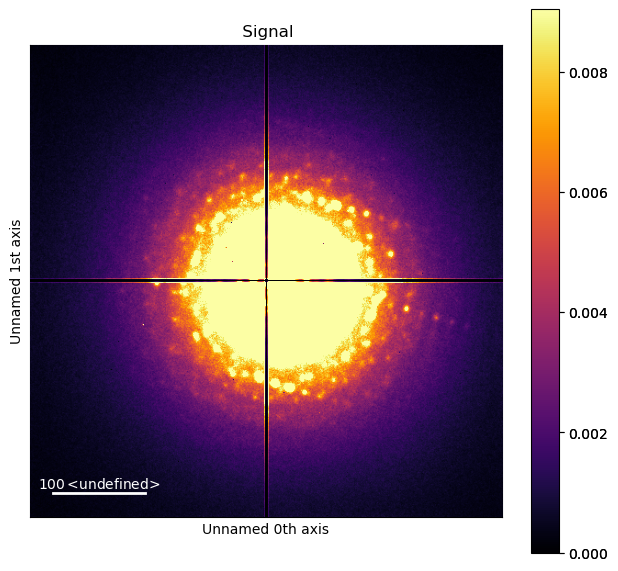

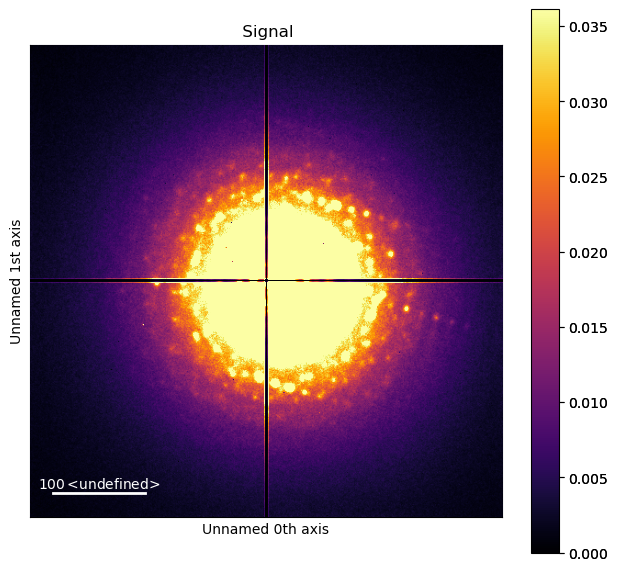

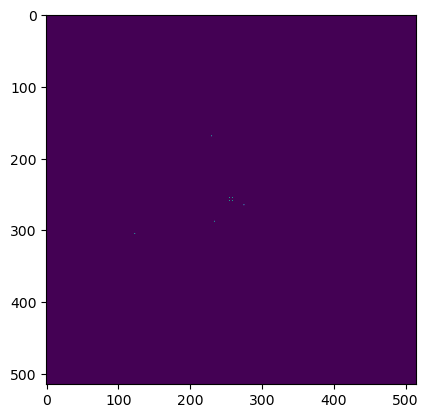

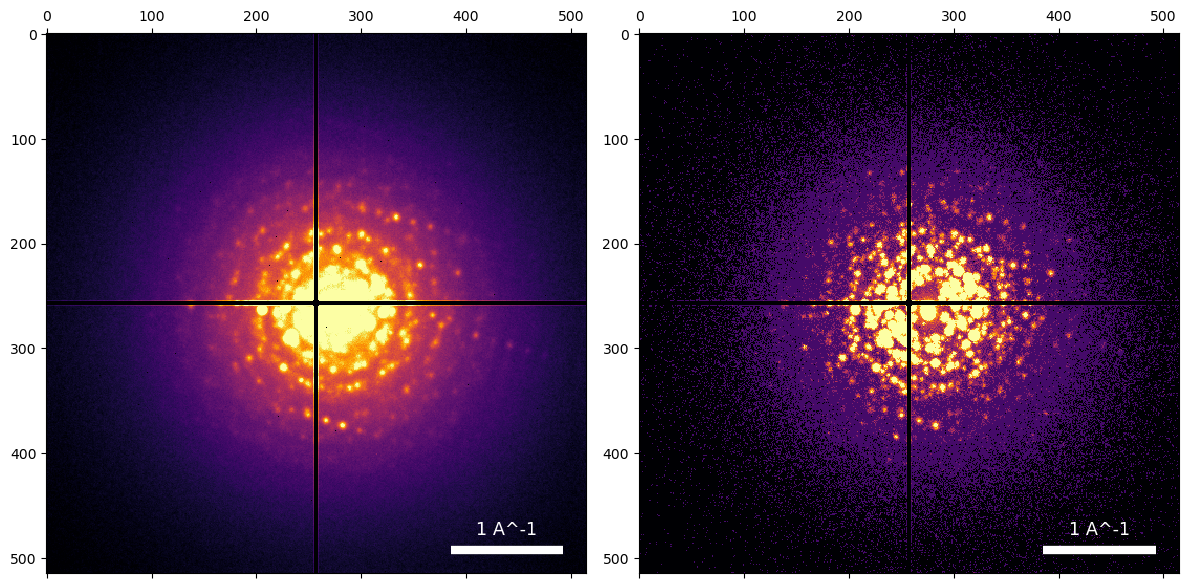

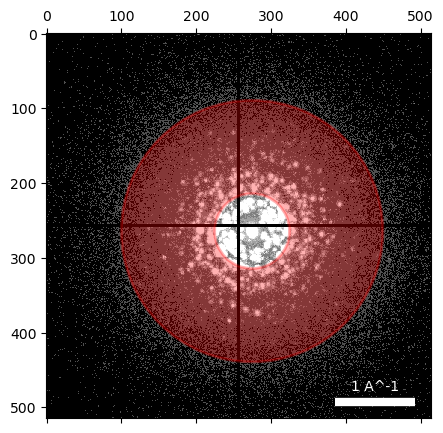

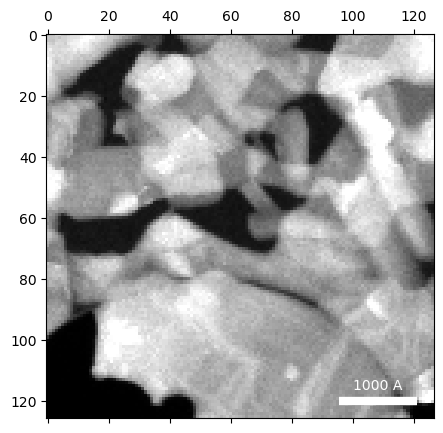

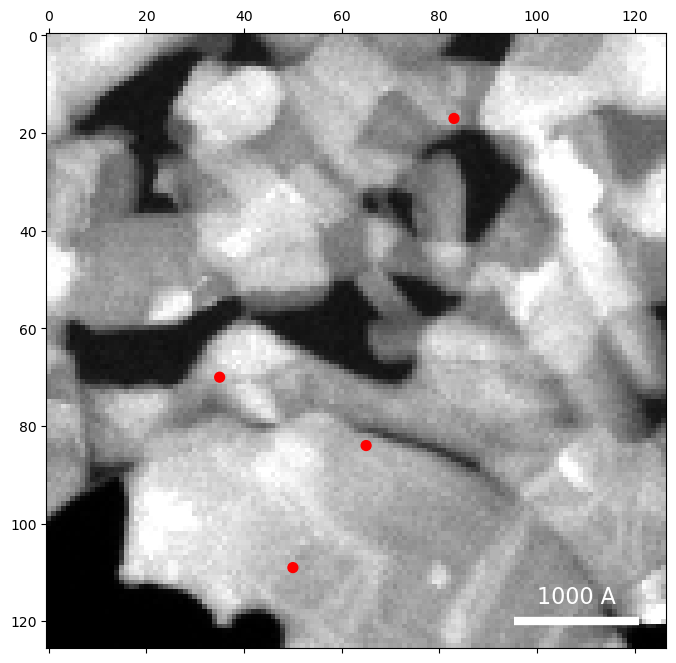

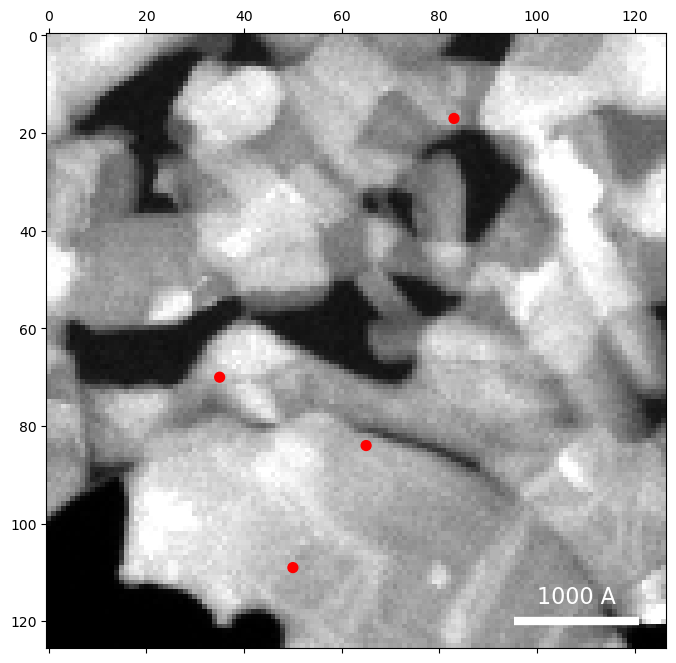

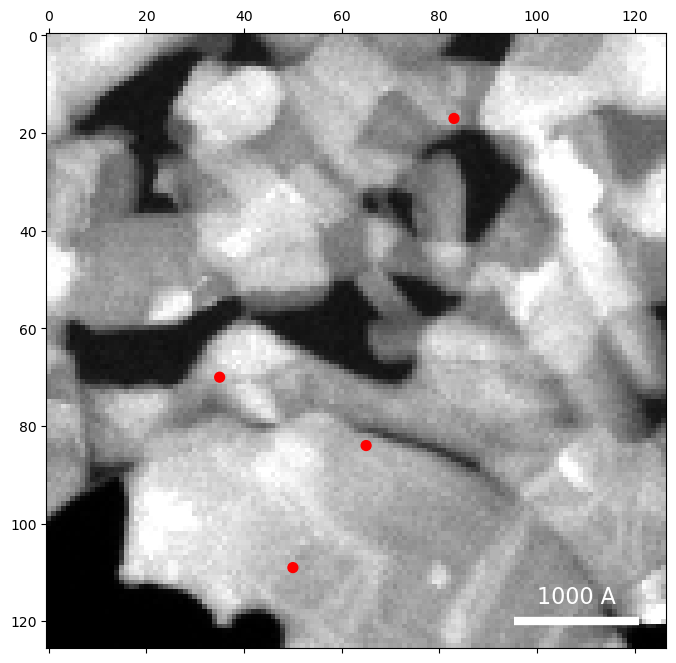

In [19]:
rxs = tuple(xy_pos[0].astype(int))#10,18,40,35,50,30
rys = tuple(xy_pos[1].astype(int)) #40,10,10,20,30,50
#colors=['r','c','r','c','r','c']

py4DSTEM.visualize.show_points(
    dataset.tree('dark_field'),
    x=xy_pos[0],
    y=xy_pos[1],
    #pointcolor=colors,
    figsize=(8,8),
    returnfig=True
)

In [ ]:
# Try making a synthetic probe
# syn_probe_rad = '4'
# syn_probe_width = '4'
syn_probe_rad = int(syn_probe_rad)
syn_probe_width = float(syn_probe_width)

syn_probe = py4DSTEM.braggvectors.probe.Probe.generate_synthetic_probe(syn_probe_rad, syn_probe_width, (dataset.data.shape[-1], dataset.data.shape[-1]))

In [ ]:
plt.figure()
plt.imshow(syn_probe.data[0, : ,: ])
plt.savefig(os.path.join(save_path,'synthetic_probe.PNG'))

In [ ]:
# Construct a probe template to use as a kernel for correlation disk detection
probe_semiangle = syn_probe_rad
probe_kernel_pre = float(probe_kernel_pre)
probe_kernel_post = float(probe_kernel_post)
syn_probe_kernel = syn_probe.get_kernel(
    mode = 'sigmoid',
    radii = (probe_semiangle * probe_kernel_pre, probe_semiangle * probe_kernel_post),
    bilinear=True,
)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    syn_probe.kernel, 
    R=20, 
    L=20, 
    W=1,
    figsize = (8,4),
)


In [ ]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions
peak_finding_minAbsoluteIntensity = float(peak_finding_minAbsoluteIntensity)
peak_finding_minPeakSpacing = int(peak_finding_minPeakSpacing)
# Hyperparameters
detect_params = {
    'corrPower': 1.0, #1.0,
    'sigma': 0,
    'edgeBoundary': 2,
    'minRelativeIntensity': 0.0,
    'minAbsoluteIntensity': peak_finding_minAbsoluteIntensity, #0.25, 
    'minPeakSpacing': peak_finding_minPeakSpacing, # 5,
    'subpixel' : 'poly',
#     'subpixel' : 'multicorr',
    'upsample_factor': 2,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    # template = probe_kernel,
    template=syn_probe_kernel,
    **detect_params,
)

fig, ax = py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=2, 
    W=2,
    axsize=(3,3),
    returnfig=True,
#     intensity_range='absolute',
#     vmin=10,
    vmax=0.98,
#     scaling='power',
    # power=0.2,
    #get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    #get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 50,
)
fig.savefig(os.path.join(save_path,'peak_finding_test.PNG'))

In [ ]:
bragg_peaks = dataset.find_Bragg_disks(
    template = syn_probe_kernel,
    **detect_params,
)

In [ ]:
# compute
bvm = bragg_peaks.histogram( mode='raw' )

# show
show(bvm)

In [ ]:
dataset.calibration

In [ ]:
bragg_peaks.setcal()

In [ ]:
bragg_peaks.calstate

In [ ]:
# Masking the cross region
mask_cross = np.zeros_like(dp.data)
width = 6
cent_x = dp.data.shape[0]/2
cent_y = dp.data.shape[1]/2
mask_cross[int(cent_x - width):int(cent_x + width), :] = 1
mask_cross[:, int(cent_y - width):int(cent_y + width)] = 1
mask_cross = mask_cross.astype('bool')
plt.figure()
plt.imshow(mask_cross)
fig = plt.gcf()
fig.savefig(os.path.join(save_path, 'cross_mask.png'))

In [ ]:
# First, generate a mask of the beamstop, plot it
dataset.get_beamstop_mask(
    threshold = 0.01,
    distance_edge = 7,
    # include_edges=False,
);
dataset.tree("mask_beamstop").data = mask_cross
py4DSTEM.show(
    dataset.tree("mask_beamstop"),
    intensity_range='absolute',
    vmin=0,
    vmax=1,
    figsize = (4,4),
)

In [ ]:
# Apply the mask to the raw bragg peaks
bragg_peaks_masked = bragg_peaks.mask_in_Q(
    dataset.tree("mask_beamstop").data,
)
# Create a bragg vector map (2D histogram of all detected bragg peaks) for both raw and masked Bragg peaks
bragg_vector_map = bragg_peaks.get_bvm(mode='raw')
bragg_vector_map_masked = bragg_peaks_masked.get_bvm(mode='raw')
# Plot a comparison image between the original and masked bragg vector map
fig, ax = py4DSTEM.show(
    [
        bragg_vector_map,
        bragg_vector_map_masked,
    ],
    combine_images = True,
    figsize = (4,4),
    returnfig=True,
)
fig.savefig(os.path.join(save_path,'bragg_peaks_masked.PNG'))

In [ ]:
# Measure the origin

qx0_meas,qy0_meas,mask_meas = bragg_peaks_masked.measure_origin(
    center_guess=(probe_qx0,probe_qy0),
    score_method='intensity weighted distance', #'distance',
    findcenter='max',
)

fig, ax = show(
    [qx0_meas,qy0_meas],
    cmap = 'RdBu',
    # mask = mask_meas,
    returnfig=True,
)
fig.savefig(os.path.join(save_path,'bragg_peaks_masked_measure_origin.PNG'))

In [ ]:
# Fit a plane to the origins

qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks_masked.fit_origin(
    robust= True,
    # robust_thresh= 1.2,
    fitfunction = 'bezier_two',
)

In [ ]:
fig = plt.gcf()
fig.savefig(os.path.join(save_path, 'BF_disc_align.png'))


In [ ]:
logger.debug(f"Calibration state: {bragg_peaks_masked.calibration}")

In [ ]:
bragg_peaks_masked.calstate

In [ ]:
# Now that we've calibrated the center positions, we can re-compute
# the Bragg vector map, this time with the center correction applied

sampling = 1

# compute
bvm = bragg_peaks_masked.histogram(
    #mode='cal',             # 'cal' is the default mode, so this line can be included or left out
    sampling = sampling,
)

# show
# overlay a circle around the center for visualization purposes
fig, ax = show(
    bvm,
    circle={
        'center' : bvm.origin,   # the centered BVM knows where its origin is 
        'R' : 4*sampling,
        'fill' : False,
        'linewidth' : 1
    },
    returnfig = True,
    #vmax=0.9
)
fig.savefig(os.path.join(save_path, 'BF_disc_align_bvm.png'))

In [ ]:
# Compare this to the uncalibrated BVM - much better!

# compute raw vs. centered
bvm_r = bragg_peaks_masked.histogram( mode='raw', sampling=sampling )
bvm_c = bragg_peaks_masked.histogram( mode='cal', sampling=sampling )

# show
show( [bvm_r, bvm_c] ,vmax=0.99)

# show, zooming in on origin
L = 20
x,y = bvm_c.origin
import numpy as np
x0,xf = np.round([x-L,x+L]).astype(int)
y0,yf = np.round([y-L,y+L]).astype(int)

show(
    [
    bvm_r[x0:xf,y0:yf],
    bvm_c[x0:xf,y0:yf]
    ],
    vmax=0.9
)

In [ ]:
fig = plt.gcf()
fig.savefig(os.path.join(save_path, 'BF_disc_align_before_after.png'))

In [ ]:
bragg_peaks_masked.calibration.set_p_ellipse(p_ellipse)

In [ ]:
logger.debug(f"Calibration state: {bragg_peaks_masked.calibration}")

In [ ]:
bragg_peaks_masked.calibration.set_QR_rotflip((0, False))

In [ ]:
bragg_peaks_masked.calstate

In [ ]:
# Save calibrated Bragg peaks
filepath_braggdisks_cali = os.path.join(save_path, f'{time_stamp}_braggdisks_cali.h5')
py4DSTEM.save(
    filepath_braggdisks_cali,
    bragg_peaks_masked,
    mode='o',
)

<!-- ## Masking the real space / carbon rimgs

qx0_fit

print(np.mean(qy0_fit), np.mean(qx0_fit))

bvm_c = bragg_peaks_masked.histogram( mode='cal', sampling=sampling )





#plot ADF and DF 
#provide center co-ords and radii:
center = (128,129) # y, x
radii = (24,32)
# radii = (45,50)
#calculate calibrated valued for virtual image
cal_center = (center[0]- bvm_c.origin[0])*bvm_c.pixelsize, (center[1]- bvm_c.origin[1])*bvm_c.pixelsize
cal_radii = radii[0] *bvm_c.pixelsize,radii[1]*bvm_c.pixelsize

show(
    [
    bvm_c
    ],
    intensity_range='absolute',
    # scaling = 'log', 
    vmax=5,
    
    annulus={
    'center' : (center),   # the centered BVM knows where its origin is 
    'radii' : radii,
    'alpha' : 0.3,
    'fill' : True,

    },
)

#calculate bf image
im_adf = bragg_peaks_masked.get_virtual_image(
    mode = 'annular', 
    geometry= ((0,0),(5 *bvm_c.pixelsize, 250 *bvm_c.pixelsize)),  
    name = 'adf_virtual_image',
)

# show(
#     im_adf,
# )

im_df = bragg_peaks_masked.get_virtual_image(
    mode = 'annular', 
    geometry= ((cal_center),(cal_radii)),  
    name = 'df_virtual_image',
)

show(
    im_df,
)


mask_np = im_df.data > 1

plt.figure()
plt.imshow(mask_np)




# set geometry
mask_x0, mask_y0 = 104,95
mask_radius = 20


# plot the mask geometry, overlaid onto the dark field image we created earlier
py4DSTEM.visualize.show(
    im_adf,
    circle = {
      'center':(mask_x0, mask_y0),
      'R': mask_radius,
      'alpha':0.3,
      'fill':True
    },
    figsize=(4,4)
)

import numpy as np
ryy,rxx = np.meshgrid(
    np.arange(dataset.R_Ny),
    np.arange(dataset.R_Nx),
)
rrr = np.hypot( rxx-mask_x0, ryy-mask_y0 )
mask = rrr < mask_radius

# show
show(
    im_adf,
    mask = mask,
    figsize=(4,4)
)

# Find the mean of the diffraction pattern in the specified region

selected_area_diffraction_01 = dataset.get_virtual_diffraction(
    method = 'mean',
    mask = mask,
    name = 'selected_area_diffraction_01'
)

# show
py4DSTEM.visualize.show(
    selected_area_diffraction_01,
    scaling='log',
    figsize=(4,4)
)

# DF image
# Get an off-axis dark-field image


# Set detector geometry
qx0_DF,qy0_DF = 67, 133
r_DF = 6
geometry = (
    (qx0_DF,qy0_DF),
    r_DF
)

# Position detection
dataset.position_detector(
    mode = 'circular',
    geometry = geometry,
    figsize = (4,4)
)

# Compute image
image_DF_01 = dataset.get_virtual_image(
    mode = 'circle',
    geometry = geometry,
    name = 'virt_dark_field_01'
)

# Show
show(
    image_DF_01,
    figsize = (4,4)
)





peaks_mask1 = bragg_peaks_masked.mask_in_R(np.invert(mask))

bvm_c_mask_1 = peaks_mask1.histogram( mode='cal', sampling=sampling )

show(bvm_c_mask_1,
    # intensity_range='absolute',
    # vmax=0.01
    scaling='log')

peaks_mask1.cal[mask_x0, mask_y0].data

from scipy.spatial import distance

len(peaks_mask1.cal[mask_x0, mask_y0].data)
centre_pos = (peaks_mask1.cal[mask_x0, mask_y0].data[0][0], peaks_mask1.cal[mask_x0, mask_y0].data[0][1])
distances = []
for i in range(1, len(peaks_mask1.cal[mask_x0, mask_y0].data) - 1):
    peak_= (peaks_mask1.cal[mask_x0, mask_y0].data[i][0], peaks_mask1.cal[mask_x0, mask_y0].data[i][1])
    distances.append(distance.euclidean(centre_pos, peak_))

distances

1 / 0.415

1 / 0.813

#function to return the experimental powder diff pattern from a bragg vector map object
from scipy.ndimage import gaussian_filter

def return_powder_diff(
    bragg_peak_obj,
    scan_mask = None, 
    bragg_k_broadening  =0.005,
    bragg_intensity_power = 1,
    bragg_k_power = 1,
    figsize = (10,4) ,
    use_mask =1,
    show_raw_data = 0
    ):
    if use_mask ==1 :
        rxy_list = np.where(scan_mask== 1)
        bigpl = np.concatenate(
            [
                bragg_peak_obj.get_vectors(
                    rxy_list[0][i],
                    rxy_list[1][i],
                    center=True,
                    ellipse=True,
                    pixel=True,
                    rotate=True,
                ).data
                for i in range(rxy_list[0].shape[0])
                #for ry in ry_list
            ]
        )
    else:
        rx_list, ry_list =  range(bragg_peak_obj.shape[0]), range(bragg_peak_obj.shape[1])
        # concatenate all peaks
        bigpl = np.concatenate(
            [
                bragg_peak_obj.get_vectors(
                    rx,
                    ry,
                    center=True,
                    ellipse=True,
                    pixel=True,
                    rotate=True,
                ).data
                for rx in rx_list
                for ry in ry_list
            ]
        )
    # if use_mask ==1 :
    #     rx_list, ry_list = np.where(scan_mask== 1)
    
    # else:
    #     rx_list, ry_list =  range(bragg_peak_obj.shape[0]), range(bragg_peak_obj.shape[1])
        
    # # concatenate all peaks
    # bigpl = np.concatenate(
    #     [
    #         bragg_peak_obj.get_vectors(
    #             rx,
    #             ry,
    #             center=True,
    #             ellipse=True,
    #             pixel=True,
    #             rotate=True,
    #         ).data
    #         for rx in rx_list
    #         for ry in ry_list
    #     ]
    # )
    
    # get radial positions and intensity
    qr = np.sqrt(bigpl["qx"] ** 2 + bigpl["qy"] ** 2)
    int_meas = bigpl["intensity"]
    
    # get discrete plot from structure factor amplitudes
    k_min = qr.min()
    k_max = qr.max()
    k_step = bragg_peak_obj.calibration.get_Q_pixel_size() /2 #(qr.max() - qr.min())/ qr.shape[0]
    k = np.arange(k_min, k_max + k_step, k_step)
    k_num = k.shape[0]
    int_exp = np.zeros_like(k)
    k_px = (qr - k_min) / k_step
    kf = np.floor(k_px).astype("int")
    dk = k_px - kf
    
    sub = np.logical_and(kf >= 0, kf < k_num)
    int_exp = np.bincount(
        np.floor(k_px[sub]).astype("int"),
        weights=(1 - dk[sub]) * int_meas[sub],
        minlength=k_num,
    )
    sub = np.logical_and(k_px >= -1, k_px < k_num - 1)
    int_exp += np.bincount(
        np.floor(k_px[sub] + 1).astype("int"),
        weights=dk[sub] * int_meas[sub],
        minlength=k_num,
    )
    
    if bragg_k_broadening > 0.0:
        int_exp = gaussian_filter(
            int_exp, bragg_k_broadening / k_step, mode="constant"
        )
    
    int_exp_plot = (int_exp**bragg_intensity_power) * (k**bragg_k_power)
    int_exp_plot /= np.max(int_exp_plot)
    return(k, int_exp_plot)

k_, int_ = return_powder_diff(bragg_peaks_masked, mask)

plt.figure()
plt.plot(k_, int_, 'r-') -->

## Applying calibrations to the Dataset

In [ ]:
dataset.calibration

In [ ]:
# apply calibrations - variable origin
dataset.calibration.set_qx0(qx0_fit)
dataset.calibration.set_qy0(qy0_fit)
dataset.calibrate()

In [ ]:
# Calculate a new mean diffraction pattern with the fitted de-scan
im_align = dataset.get_virtual_diffraction(
    method = 'mean',
    shift_center = True,
)

In [ ]:
# Compare the two mean diffraction patterns:
py4DSTEM.show(
    # [
        dataset.tree('dp_mean').data - im_align.data,
        # im_align,
    # ],
    ticks = False,
    # combine_images = True,
    # figsize = (12,12),
    # vmax = 1.0,
)

In [ ]:
# apply elliptic calibrations
dataset.calibration.set_p_ellipse(p_ellipse)
dataset.calibrate()

In [ ]:
dataset.calibration

## Polar Transform

In [ ]:

polardata = py4DSTEM.PolarDatacube(
    dataset,
    qmin = 0,
    qmax = None,
    qstep = 1.0,
    n_annular = 180,
   # two_fold_symmetry = True,
    # mask = fitting_mask,
    qscale = 1.0,
)

In [ ]:
# show polar transformation for different probe positions.
# note the first few probe positions are massively shifted from the correct center!

# x,y = 10,25
x,y = 60,90
# x,y = 19,49

# Show pattern in cartesian + polar
fig,ax = py4DSTEM.show( 
    [
        # dataset.data[x,y],
        gaussian_filter(dataset.data[x,y],1),
        polardata.data[x,y],
    ],
    axsize = (4,4),
    ticks = False,
    returnfig = True,
    cmap = 'turbo',
    # vmax = 1,
    scaling = 'log',
)

In [ ]:
polardata.calculate_radial_statistics(
    plot_results_mean = True,
    # plot_results_var=True,
)    

In [ ]:
polardata.plot_radial_var_norm(
)

In [ ]:
show(polardata.data[x, y])

In [ ]:
polardata.data[x, y]

In [ ]:
local_radial_mean, local_radial_var = polardata.calculate_FEM_local(
    use_median=False,
    return_values=True,
)

In [ ]:
local_radial_var = hs.signals.Signal2D(local_radial_var)
local_radial_mean = hs.signals.Signal2D(local_radial_mean)


In [ ]:
local_radial_var = local_radial_var.transpose(signal_axes=1)
local_radial_mean = local_radial_mean.transpose(signal_axes=1)

In [ ]:
local_radial_var.plot()
local_radial_mean.plot()

In [ ]:
# py4DSTEM.io.save(os.path.join(save_path, f'{time_stamp}_polar_data.h5'), polardata)

In [ ]:
local_radial_var.axes_manager[-1].scale = pixel_size_inv_Ang
local_radial_var.axes_manager[-1].units = '1/A'
local_radial_var.axes_manager[-1].name = 'Scattering angle'
local_radial_mean.axes_manager[-1].scale = pixel_size_inv_Ang
local_radial_mean.axes_manager[-1].units = '1/A'
local_radial_mean.axes_manager[-1].name = 'Scattering angle'

In [ ]:
local_radial_var.axes_manager
local_radial_mean.axes_manager

In [ ]:
local_radial_var.save(os.path.join(save_path, f'{time_stamp}_variance.hspy'))
local_radial_mean.save(os.path.join(save_path, f'{time_stamp}_mean.hspy'))

In [ ]:
local_radial_var_sum = local_radial_var.sum()
local_radial_mean_sum = local_radial_mean.sum()

In [ ]:
local_radial_var_sum.plot()
local_radial_mean_sum.plot()

In [ ]:
peaks = find_peaks(local_radial_var_sum.data)
peaks = pixel_size_inv_Ang * peaks[0]

peaks_mean = find_peaks(local_radial_mean_sum.data)
peaks_mean = pixel_size_inv_Ang * peaks_mean[0]

In [ ]:
local_radial_var_sum.data.shape
local_radial_mean_sum.data.shape

In [ ]:
plt.figure()
x_axis = pixel_size_inv_Ang * np.arange(local_radial_var_sum.data.shape[0])
plt.plot(x_axis, local_radial_var_sum.data)

for peak in peaks:
    # print(peak)
    plt.axvline(peak, ls=':', lw=0.5)
fig = plt.gcf()
fig.savefig(os.path.join(save_path, 'sum_variance_peaks.png'))

plt.figure()
x_axis = pixel_size_inv_Ang * np.arange(local_radial_mean_sum.data.shape[0])
plt.plot(x_axis, local_radial_mean_sum.data)

for peak in peaks:
    # print(peak)
    plt.axvline(peak, ls=':', lw=0.5)
fig = plt.gcf()
fig.savefig(os.path.join(save_path, 'sum_mean_peaks.png'))